Script for generating figure 1 illustrating the model control state. 
- Fig. 1: Comparison of Antarctic water-mass properties in ACCESS-OM2-01 with observations. Conservative temperature (a, b) and absolute salinity (c, d) of Antarctic Shelf Bottom Water (ASBW, shading poleward of black contour) and Circumpolar Deep Water (CDW, shading north of black contour) partitioned by the 1000 m isobath (black contour). Observational estimates (a, c) are from \citet{Schmidtko2014}, based on 1975-2012 data. Model values (b, d) shown are averaged over the 10 year control simulation. ABSW is defined as the bottom ocean cell on the Antarctic continental shelf.  Following \citet{Schmidtko2014}, CDW characteristics are taken at the conservative temperature maximum below the Winter Water depth, where the Winter Water depth is defined as the conservative temperature minimum below 40 m depth. CDW is undefined where this conservative temperature maximum exceeds 2.8$^\circ$C. Regions where data are unavailable or water-mass definitions are unsatisfied are in white.

In [19]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import matplotlib.colors as col
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.path as mpath
# import matplotlib.patches as mpatches
# from matplotlib.transforms import offset_copy
# import matplotlib.path as mpath
import sys
sys.path.append('/home/156/rm2389/Honours_Thesis/python_functions/')
from masking import shelf_mask_isobath, fill_land
from spatial_averaging import month_weights
import cosima_cookbook as cc
from matplotlib import gridspec
# from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
from matplotlib import rc, rcParams
rc('text', usetex=True)
import cmocean.cm as cmo
from gsw import SA_from_SP, p_from_z, CT_from_pt, sigma1
import matplotlib.ticker as mticker
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
from dask.distributed import Client
client = Client('tcp://localhost:8786')
client

Client Scheduler: tcp://localhost:8786 Dashboard: http://localhost:8787/status,Cluster Workers: 6 Cores: 6 Memory: 18.00 GB


In [3]:
rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
rc('xtick', labelsize=40) 
rc('ytick', labelsize=40) 
rc('axes', labelsize=40) 

In [4]:
db = '/g/data/v45/rm2389/databases/freshwater_experiments.db' # database path
session = cc.database.create_session(db)
control='01deg_jra55v13_ryf8485_spinup6'

The CDW and ASBW tracers were computed in a different notebook and saved. Below I have outlined the process (takes a little while so I wont repeat).

Because the model output PSU and PT, I used TEOS-10 functions to generate arrays of AS and CT. I think I needed to have different files for each year as the computations were demanding. Then I masked these values as below before taking the time mean over the 10 year control simulation.

# Model output:

### ASBW masking:
This one is simple, just the bottommost cell on the continental shelf.
```
dummy = cc.querying.getvar(control, 'temp',session,ncfile = 'ocean.nc', n=1)
dummy, shelf_map  = shelf_mask_isobath(dummy)
dummy = dummy * 0 + 1
depth_array = dummy * 0 + dummy.st_ocean
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)
bottom_mask = depth_array.where(depth_array.st_ocean >= max_depth) * 0 + 1
bottom_mask = bottom_mask.squeeze(dim = 'time')
```
Then use the following function.
```
def bottom_temp(var, bottom_mask = bottom_mask):
    masked_var = var * bottom_mask
    masked_var = masked_var.sum(dim = 'st_ocean')
    masked_var = masked_var.where(masked_var != 0)
    masked_var = masked_var - 273.15
    return masked_var
 ```
Say we have some CT file: 
```
temp_year10 = xr.open_dataset('/g/data/v45/rm2389/Water_Mass_Tracers/CT_control_1946-06-1947-05.nc', chunks = {'time':1, 'yt_ocean':300, 'xt_ocean':300, 'st_ocean':None})
bottom_temp_year10 = bottom_temp(temp_year10)
```
Such things were claculated and saved to be recalled.

### CDW masking:
This is more complicated. The CDW depth is defined by Schmidtko et al 2014 as the conservative temperature maximum below the Winter Water depth, where the Winter Water depth is defined as the conservative temperature minimum below 40 m depth. So first we need to find the Winter Water depth.

Using the same `temp` variable above.
Find the minimum temperature value where `st_ocean` is less than 40m.
```
WW_temp_year10 = temp_year10.sel(st_ocean = slice(40,None)).min(dim = 'st_ocean', skipna = True)
```
Then, since what we actually want to do is mask for all ocean grid cells deeper than the local WW depth, we generate a mask using the above array.

```
depth_array10 = (WW_temp_year10 * 0 + 1) * temp_year10.st_ocean ## array of st_ocean with same dimensions as time, st_ocean, xt_ocean, yt_ocean

WW_depth10 = depth_array10.where(temp_year10 == WW_temp_year10) ## array with depth where the temp is the WW temp and nans elsewhere

WW_depth10 = WW_depth10.sel(st_ocean = slice(40, None)).min(dim = 'st_ocean') ## shallowest depth where this occurs, shallower than 40m

below_WW_mask10 = depth_array10.where(depth_array10 > WW_depth10) * 0 + 1

```
Now we an get the CDW temperature, as the maximum temperature below the WW depth.

```
CDW_temp10 = (temp_year10 * below_WW_mask10).max(dim = 'st_ocean', skipna = True)
```
But we also want to have the CDW salinity, so, say we have the absolute salinity field for that year
```
salt_year10 = xr.open_dataset('/g/data/v45/rm2389/Water_Mass_Tracers/AS_control_1946-06-1947-05.nc', chunks = {'time':1, 'yt_ocean':300, 'xt_ocean':300, 'st_ocean':None})
```
we determine the CDW depth at each horizontal grid space and time
```
CDW_depth10 = depth_array10 * below_WW_mask10
CDW_depth10 = CDW_depth10.where((temp_year10 * below_WW_mask10) == CDW_temp10)
CDW_depth10 = CDW_depth10.min(dim = 'st_ocean')
```
and then get the salinity at that depth for each grid space and time
```
CDW_salt10 = salt_year10.where(depth_array10 == CDW_depth10).sum(dim = 'st_ocean')
```
This was done for each of the 10 years of the control simulation and then concatenated and saved as a 10 year monthly 2D (spatial) field.

# Schmidtko et al 2014 observational fields

Data source: https://www.geomar.de/en/staff/fb1/po/sschmidtko/southern-ocean/
Had to muck about with the dimensions but it's all saved now.

In [11]:
## data required for lat/lon mapping and bathymetry contours
ht = cc.querying.getvar(control,'ht',session, n=1) 
ht = ht.sel(yt_ocean = slice(-90,-55))
land_mask = np.squeeze(ht.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yt_ocean =ht.yt_ocean.values
xt_ocean =ht.xt_ocean.values
ht_shelf , shelf_mask = shelf_mask_isobath(ht)

In [13]:
## load the observed Schmidtko fields
CDW_Observed = xr.open_dataset('/g/data/v45/rm2389/Schmidtko_Observations/CDW_Temp_Salt_new.nc')
AASW_Observed = xr.open_dataset('/g/data/v45/rm2389/Schmidtko_Observations/AASW_Temp_Salt.nc')
CDW_CT = CDW_Observed.CT
CDW_AS = CDW_Observed.AS
AASW_CT = AASW_Observed.CT
AASW_AS = AASW_Observed.AS
CDW_CT_masked = CDW_CT.sel(lat = slice(-80,-55))
CDW_AS_masked = CDW_AS.sel(lat = slice(-80,-55))

In [14]:
## load the model fields (bottom waters) and take the time mean
bottom_con_temp_control = xr.open_dataset('/g/data/v45/rm2389/Water_Mass_Tracers/bottom_CT_control.nc', chunks= {'time':None, 'yt_ocean':300, 'xt_ocean':400})
bottom_abs_salt_control = xr.open_dataset('/g/data/v45/rm2389/Water_Mass_Tracers/bottom_AS_control.nc', chunks= {'time':None, 'yt_ocean':300, 'xt_ocean':400})
bottom_con_temp_control = bottom_con_temp_control.bottom_temp
bottom_abs_salt_control = bottom_abs_salt_control.bottom_salt
time = bottom_con_temp_control.time.values
weights = xr.DataArray(month_weights(start_month=6, end_month=5, n_years=1), coords = [time], dims = 'time')
weights = weights.chunk({'time':1})
bottom_con_temp_control = (bottom_con_temp_control * weights).mean(dim = 'time')
bottom_abs_salt_control = (bottom_abs_salt_control * weights).mean(dim = 'time')
bottom_con_temp_control = bottom_con_temp_control.load()
bottom_abs_salt_control = bottom_abs_salt_control.load()

In [15]:
CDW_temp = xr.open_dataset('/g/data/v45/rm2389/Water_Mass_Tracers/CDW_CT_control_timeseries_1942-06-1947-05.nc', chunks = {'time':None, 'yt_ocean':500, 'xt_ocean':500})
CDW_temp = CDW_temp.CDW_temp
CDW_temp_mean = (CDW_temp).mean(dim = 'time')
CDW_salt = xr.open_dataset('/g/data/v45/rm2389/Water_Mass_Tracers/CDW_AS_control_timeseries_1942-06-1947-05.nc', chunks = {'time':None, 'yt_ocean':500, 'xt_ocean':500})
CDW_salt = CDW_salt.CDW_salt
CDW_salt = CDW_salt.where(CDW_salt>0)
CDW_salt_mean = (CDW_salt).mean(dim = 'time') # for some reason the weighted mean was wacky

Now, what I pictured was a plot that showed ASBW values on the shelf and CDW values off the shelf, on the same map, separated by an isobath contour. So to do that I need to do some janky masking.

In [16]:
## create a mask that masks OUT the shelf (opposite of function shelf_mask_isobath)
yt_ocean_full = CDW_salt_mean.yt_ocean
yt_ocean_add = yt_ocean_full.sel(yt_ocean = slice(-59, None))
extra_rows = np.zeros((74,3600))
shelf_mask_extended = np.append(shelf_mask.values, extra_rows, axis = 0)
shelf_mask_ext  = xr.DataArray(shelf_mask_extended,coords = [('yt_ocean', yt_ocean_full), ('xt_ocean', xt_ocean)] )
shelf_mask_ext = shelf_mask_ext.where(shelf_mask_ext == 0) + 1
CDW_salt_mean = CDW_salt_mean * shelf_mask_ext
CDW_salt_mean=CDW_salt_mean.load()
CDW_temp_mean = CDW_temp_mean * shelf_mask_ext
CDW_temp_mean = CDW_temp_mean.load()

In [20]:
## some stuff that I always plot when doing circumantarctic thingies
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
def antarctic_map(ax, isobath_linewidth, grid, north, isobath_colour = 'k'):
    ax.contour(xt_ocean, yt_ocean,land_mask,[0,1], colors = 'k', linewidth = 1, alpha = 0.3, transform=ccrs.PlateCarree())
    ax.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean,shelf_mask,[0,1], colors = isobath_colour, linewidth = isobath_linewidth, transform=ccrs.PlateCarree())
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([-180, 180, -90, north], ccrs.PlateCarree())
    if grid == True:
        gl = ax.gridlines(linewidth = 1, color = 'grey', linestyle = '--')
        gl.ylocator = mticker.FixedLocator([-90,-80,-70, -60, -50])

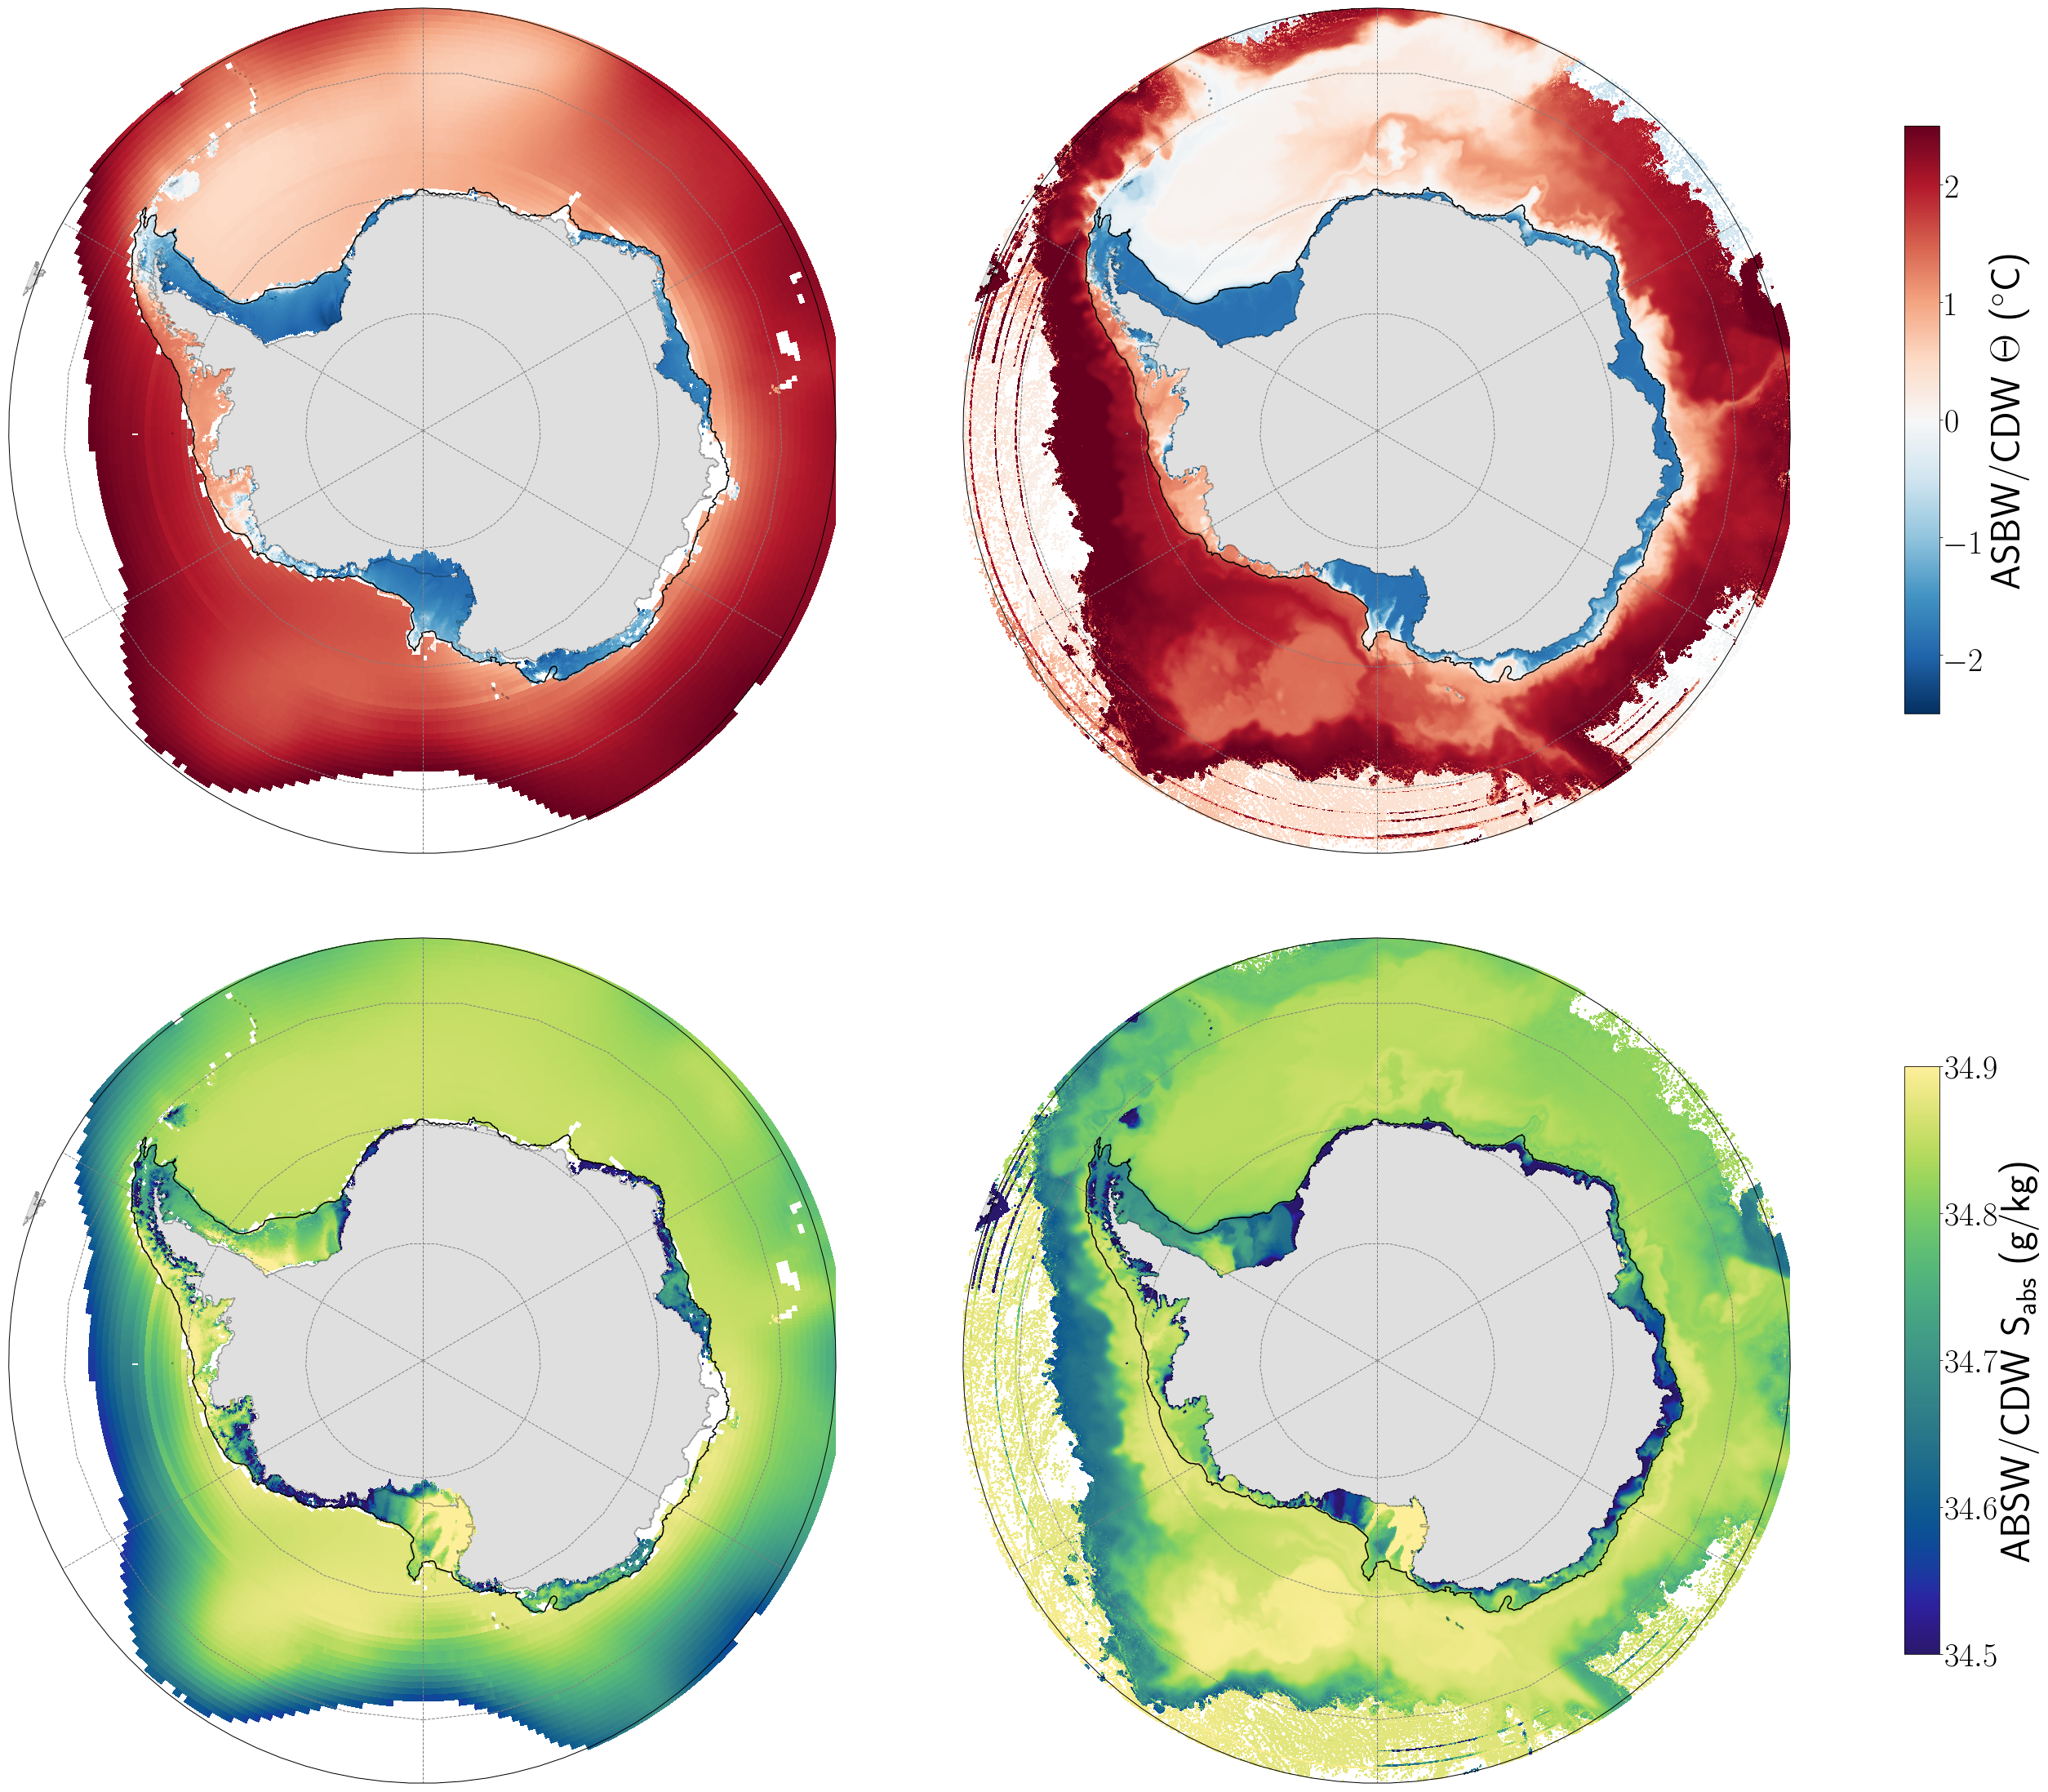

In [22]:
fig, ax  = plt.subplots(2,2, figsize = (40,40))
gs = gridspec.GridSpec(2,2)
ax0, ax1, ax2, ax3 = plt.subplot(gs[0,0],projection=ccrs.SouthPolarStereo()), plt.subplot(gs[0,1],projection=ccrs.SouthPolarStereo()),plt.subplot(gs[1,0],projection=ccrs.SouthPolarStereo()), plt.subplot(gs[1,1],projection=ccrs.SouthPolarStereo())
gs.update(hspace = 0.1, wspace = 0.1)
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

## fill continent (silver)
fill_land(land_mask, ax0, yt_ocean, xt_ocean, fill_colour = 'silver', a = 0.5)
fill_land(land_mask, ax1, yt_ocean, xt_ocean, fill_colour = 'silver', a = 0.5)
fill_land(land_mask, ax2, yt_ocean, xt_ocean, fill_colour = 'silver', a = 0.5)
fill_land(land_mask, ax3, yt_ocean, xt_ocean, fill_colour = 'silver', a = 0.5)
    
## CDW
norm = col.Normalize(vmin=-2.5,vmax=2.5)
ax0.pcolormesh(CDW_CT_masked.lon, CDW_CT_masked.lat, CDW_CT_masked,cmap='RdBu_r',norm=norm,transform=ccrs.PlateCarree())
ax0.pcolormesh(AASW_CT.lon, AASW_CT.lat, AASW_CT,cmap='RdBu_r',norm=norm,transform=ccrs.PlateCarree())
CDW_temp = ax1.pcolormesh(CDW_temp_mean.xt_ocean,CDW_temp_mean.yt_ocean,CDW_temp_mean.values,cmap='RdBu_r',norm=norm,transform=ccrs.PlateCarree())
ASBW_temp = ax1.pcolormesh(bottom_con_temp_control.xt_ocean,bottom_con_temp_control.yt_ocean,bottom_con_temp_control.values,cmap='RdBu_r',norm=norm,transform=ccrs.PlateCarree())
# mapping 
antarctic_map(ax0, isobath_linewidth = 6, grid = True, north = -55)
antarctic_map(ax1, isobath_linewidth = 6, grid = True, north = -55)

## CDW
norm = col.Normalize(vmin=34.5,vmax=34.9)
control_salt = ax2.pcolormesh(CDW_AS_masked.lon, CDW_AS_masked.lat, CDW_AS_masked,cmap=cmo.haline,norm = norm, transform=ccrs.PlateCarree())
ax2.pcolormesh(AASW_AS.lon, AASW_AS.lat, AASW_AS,cmap=cmo.haline,norm=norm,transform=ccrs.PlateCarree())
ax3.pcolormesh(CDW_salt_mean.xt_ocean,CDW_salt_mean.yt_ocean,CDW_salt_mean.values, cmap=cmo.haline,norm=norm,transform=ccrs.PlateCarree())
ax3.pcolormesh(bottom_abs_salt_control.xt_ocean,bottom_abs_salt_control.yt_ocean,bottom_abs_salt_control.values, cmap=cmo.haline,norm=norm,transform=ccrs.PlateCarree())
## mapping
antarctic_map(ax2, isobath_linewidth = 6, grid = True, north = -55)
antarctic_map(ax3, isobath_linewidth = 6, grid = True, north = -55)

## temperature colorbar
cax = fig.add_axes([0.94, 0.58, 0.015, 0.25])
cbar=plt.colorbar(CDW_temp,cax = cax,orientation='vertical',shrink = 0.5, ticks = [ -2,-1, 0, 1.0,2.0])
cbar.set_label(r'ASBW/CDW $\Theta$ ($^\circ$C)', fontsize = 50)
# ## salinity colorbar
cax = fig.add_axes([0.94, 0.18, 0.015, 0.25])
cbar=plt.colorbar(control_salt,cax = cax,orientation='vertical',shrink = 0.5, ticks = [34.5, 34.6, 34.7,34.8,34.9])
cbar.set_label(r'ABSW/CDW S$_\text{abs}$ (g/kg)', fontsize = 50)

figurepath = 'Fig1.png'
fig.savefig(figurepath, dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format='png',
            transparent=False, bbox_inches='tight', pad_inches=0.1,
            frameon=None)

plt.show()   

Ideally I would create some kind of mask that gets rid of the noise past the continuous northern boundary of the water-mass, but I dont really know how to do that in python so I did the same thing effectively by editting the png.